# Author's Notes

From [Hands-on Unsupervised Learning using Python](https://amzn.to/2tVABNx) - Chapter 13 - Temporal Clustering

Note for Mac Users: The **tslearn** library is not compatible with M1 chips yet. Please use Google Colab to run this notebook if you are using an M1 chip.

Data courtesy of the [The UCR Time Series Classification Archive](https://www.cs.ucr.edu/~eamonn/time_series_data/).

# Google Colab Setup
**Only for users on Google Colab**

In [1]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")

Mounted at /content/drive
Original path:  /content
New path:  /content/drive/My Drive/github/handson-unsupervised-learning


In [2]:
# Install additional libraries
!pip install kshape==1.0.1
!pip install tslearn==0.5.0.5
!pip install hdbscan==0.8.27

# Import Libraries

In [3]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn.metrics import adjusted_rand_score
import random

'''Algos'''
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape, TimeSeriesKMeans
import hdbscan

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


# Data Preparation

In [4]:
# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', ''])
data_train = np.loadtxt(current_path+file+
                        "ECGFiveDays/ECGFiveDays_TRAIN", 
                        delimiter=",")
X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)

data_test = np.loadtxt(current_path+file+
                       "ECGFiveDays/ECGFiveDays_TEST", 
                       delimiter=",")
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

In [5]:
# Basic summary statistics
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 23
Number of unique classes: 2
Time series length: 136


In [6]:
# Number of examples in each class in the training set
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))

Number of time series in class 1.0: 14
Number of time series in class 2.0: 9


Plot  0  Class  1.0


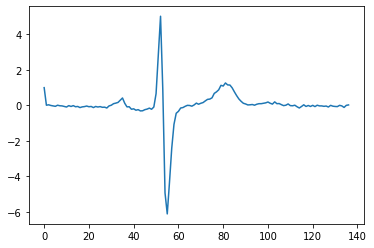

Plot  1  Class  1.0


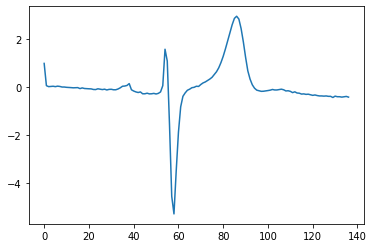

Plot  4  Class  1.0


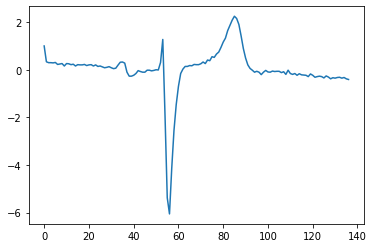

Plot  7  Class  1.0


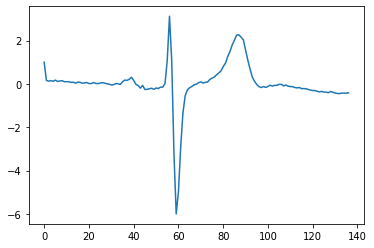

Plot  9  Class  1.0


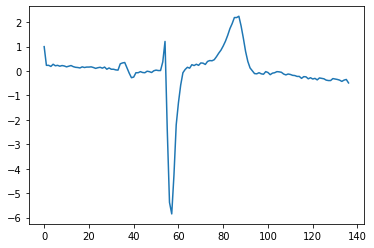

In [7]:
for i in range(0,10):
    if data_train[i,0]==1.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

Plot  2  Class  2.0


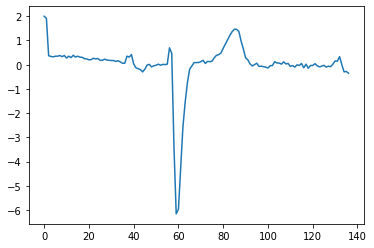

Plot  3  Class  2.0


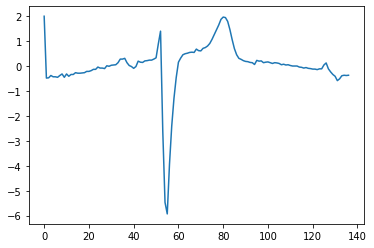

Plot  5  Class  2.0


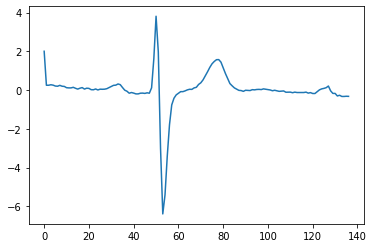

Plot  6  Class  2.0


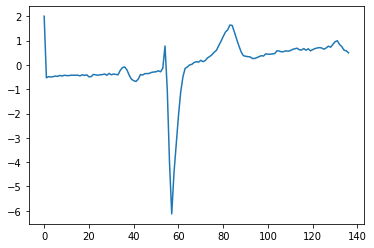

Plot  8  Class  2.0


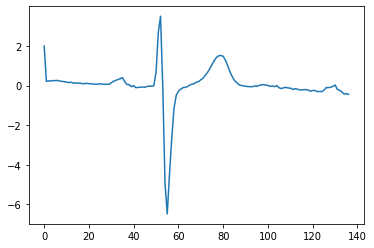

In [8]:
# Examples of Class 2.0
for i in range(0,10):
    if data_train[i,0]==2.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

In [9]:
# Prepare the data - Scale
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

# k-Shape Algorithm

In [10]:
# Train using k-Shape
ks = KShape(n_clusters=2, max_iter=100, n_init=100,verbose=0)
ks.fit(X_train)

KShape(init='random', max_iter=100, n_clusters=2, n_init=100, random_state=None,
       tol=1e-06, verbose=0)

In [11]:
# Make predictions on train set and calculate adjusted Rand index
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.668041237113402


In [12]:
# Make predictions on test set and calculate adjusted Rand index
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.0006332050676187496


# Explore ECG 5000

In [13]:
# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', ''])
data_train = np.loadtxt(current_path+file+
                        "ECG5000/ECG5000_TRAIN", 
                        delimiter=",")

data_test = np.loadtxt(current_path+file+
                       "ECG5000/ECG5000_TEST", 
                       delimiter=",")

data_joined = np.concatenate((data_train,data_test),axis=0)
data_train, data_test = train_test_split(data_joined, 
                                    test_size=0.20, random_state=2019)

X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

In [14]:
# Summary statistics
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 4000
Number of unique classes: 5
Time series length: 140


In [15]:
# Calculate number of readings per class
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))
print("Number of time series in class 3.0:", 
      len(data_train[data_train[:,0]==3.0]))
print("Number of time series in class 4.0:", 
      len(data_train[data_train[:,0]==4.0]))
print("Number of time series in class 5.0:", 
      len(data_train[data_train[:,0]==5.0]))

Number of time series in class 1.0: 2327
Number of time series in class 2.0: 1423
Number of time series in class 3.0: 75
Number of time series in class 4.0: 156
Number of time series in class 5.0: 19


 Class  1.0  Count  2327


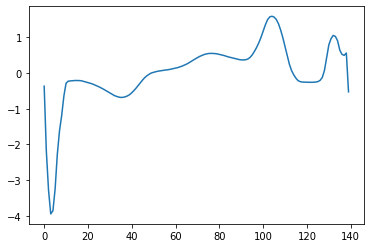

 Class  2.0  Count  1423


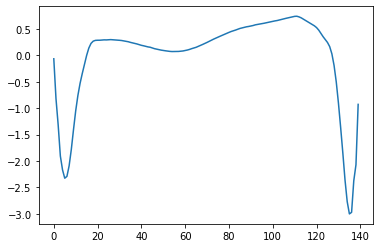

 Class  3.0  Count  75


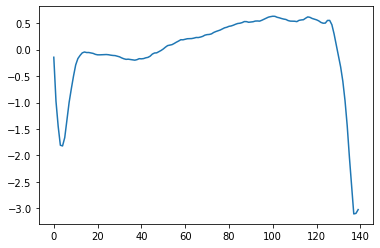

 Class  4.0  Count  156


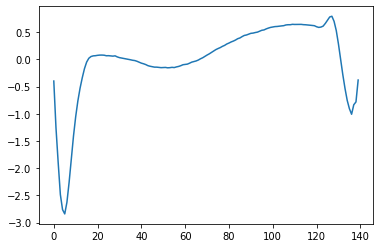

 Class  5.0  Count  19


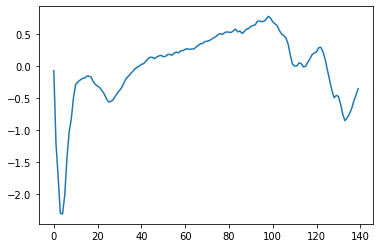

In [16]:
# Display readings from each class
for j in np.unique(data_train[:,0]):
    dataPlot = data_train[data_train[:,0]==j]
    cnt = len(dataPlot)
    dataPlot = dataPlot[:,1:].mean(axis=0)
    print(" Class ",j," Count ",cnt)
    plt.plot(dataPlot)
    plt.show()

In [17]:
# Prepare data - Scale
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

# Test Time Series Clustering Algos on Sample of ECG 5000

## k-Shape 

In [18]:
# Train using k-Shape
ks = KShape(n_clusters=5, max_iter=100, n_init=10,verbose=1,random_state=2019)
ks.fit(X_train)

Init 1
0.015 --> 0.015 --> 
Init 2
0.014 --> 0.014 --> 
Init 3
0.018 --> 0.017 --> 0.018 --> 
Init 4
0.017 --> 0.016 --> 0.018 --> 
Init 5
0.016 --> 0.017 --> 
Init 6
0.012 --> 0.012 --> 
Init 7
0.016 --> 0.014 --> 0.016 --> 
Init 8
0.015 --> 0.014 --> 0.015 --> 
Init 9
0.017 --> 0.017 --> 0.018 --> 
Init 10
0.015 --> 0.016 --> 


KShape(init='random', max_iter=100, n_clusters=5, n_init=10, random_state=2019,
       tol=1e-06, verbose=1)

In [19]:
# Predict on train set and calculate adjusted Rand index
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.5553639462811412


In [20]:
# Predict on test set and calculate adjusted Rand index
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.5301670526070555


In [21]:
# Evaluate goodness of the clusters
preds_test = preds_test.reshape(1000,1)
preds_test = np.hstack((preds_test,data_test[:,0].reshape(1000,1)))
preds_test = pd.DataFrame(data=preds_test)
preds_test = preds_test.rename(columns={0: 'prediction', 1: 'actual'})

counter = 0
for i in np.sort(preds_test.prediction.unique()):
    print("Predicted Cluster ", i)
    print(preds_test.actual[preds_test.prediction==i].value_counts())
    print()
    cnt = preds_test.actual[preds_test.prediction==i] \
                        .value_counts().iloc[1:].sum()
    counter = counter + cnt
print("Count of Non-Primary Points: ", counter)

Predicted Cluster  0.0
2.0    127
3.0      9
4.0      6
5.0      1
Name: actual, dtype: int64

Predicted Cluster  1.0
2.0    197
1.0     18
4.0      9
3.0      3
Name: actual, dtype: int64

Predicted Cluster  2.0
4.0    18
2.0    18
5.0     3
1.0     2
3.0     2
Name: actual, dtype: int64

Predicted Cluster  3.0
1.0    130
3.0      3
4.0      2
5.0      1
2.0      1
Name: actual, dtype: int64

Predicted Cluster  4.0
1.0    442
3.0      4
4.0      3
2.0      1
Name: actual, dtype: int64

Count of Non-Primary Points:  86


## Time Series k-Means

In [22]:
# Train using Time Series k-Means
km = TimeSeriesKMeans(n_clusters=5, max_iter=100, n_init=100, \
                      metric="euclidean", verbose=1, random_state=2019)
km.fit(X_train)

Init 1
36.241 --> 27.298 --> 26.273 --> 25.556 --> 25.120 --> 24.911 --> 24.831 --> 24.815 --> 24.813 --> 24.812 --> 24.812 --> 24.812 --> 24.812 --> 
Init 2
37.226 --> 25.264 --> 24.680 --> 24.430 --> 24.296 --> 24.202 --> 24.155 --> 24.136 --> 24.128 --> 24.124 --> 24.121 --> 24.119 --> 24.118 --> 24.117 --> 24.117 --> 24.117 --> 24.117 --> 24.116 --> 24.116 --> 24.116 --> 24.116 --> 24.115 --> 24.115 --> 24.115 --> 24.114 --> 24.113 --> 24.112 --> 24.111 --> 24.110 --> 24.109 --> 24.108 --> 24.108 --> 24.108 --> 
Init 3
33.738 --> 25.341 --> 25.014 --> 24.795 --> 24.664 --> 24.623 --> 24.616 --> 24.615 --> 24.614 --> 24.614 --> 24.614 --> 
Init 4
30.531 --> 24.956 --> 24.740 --> 24.663 --> 24.629 --> 24.615 --> 24.603 --> 24.595 --> 24.585 --> 24.567 --> 24.560 --> 24.559 --> 24.559 --> 24.559 --> 24.559 --> 24.559 --> 24.559 --> 
Init 5
34.030 --> 25.598 --> 25.398 --> 25.344 --> 25.310 --> 25.277 --> 25.236 --> 25.159 --> 25.005 --> 24.834 --> 24.725 --> 24.666 --> 24.636 --> 24.6

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=100,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=5, n_init=100, n_jobs=None,
                 random_state=2019, tol=1e-06, verbose=1)

In [23]:
# Predict on training set and evaluate using adjusted Rand index
preds = km.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index of Time Series k-Means on Training Set:", ars)

Adjusted Rand Index of Time Series k-Means on Training Set: 0.5063464656715959


In [24]:
# Predict on test set and evaluate using adjusted Rand index
preds_test = km.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index of Time Series k-Means on Test Set:", ars)

Adjusted Rand Index of Time Series k-Means on Test Set: 0.4864981997585834


## HDBSCAN

In [25]:
# Train model and evaluate on training set
min_cluster_size = 5
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'
prediction_data = True

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
                      min_samples=min_samples, alpha=alpha, \
                      cluster_selection_method=cluster_selection_method, \
                      prediction_data=prediction_data)

preds = hdb.fit_predict(X_train.reshape(4000,140))
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.7689563655060421


In [26]:
# Predict on test set and evaluate
preds_test = hdbscan.prediction.approximate_predict( \
                hdb, X_test.reshape(1000,140))
ars = adjusted_rand_score(data_test[:,0],preds_test[0])
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.7200816245545564


# Compare Time Series Clustering Algos on Full ECG 5000 Dataset

In [27]:
# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', ''])

mypath = current_path + file
d = []
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    for i in dirnames:
        newpath = os.path.sep.join([mypath, i, ""])
        onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
        f.extend(onlyfiles)
    d.extend(dirnames)
    break

## k-Shape Experiment - FULL RUN

In [28]:
# Create dataframe
kShapeDF = pd.DataFrame(data=[],index=[v for v in d], \
                        columns=["Train ARS","Test ARS"])

In [29]:
# Train and Evaluate k-Shape
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))
        return (time.time() - self.start_time)

timer = ElapsedTimer()
cnt = 0
for i in d:
    cnt += 1
    print("Dataset ", cnt)
    newpath = os.path.sep.join([mypath, i, ""])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    j = onlyfiles[0]
    k = onlyfiles[1]
    data_train = np.loadtxt(newpath+j, delimiter=",")
    data_test = np.loadtxt(newpath+k, delimiter=",")

    data_joined = np.concatenate((data_train,data_test),axis=0)
    data_train, data_test = train_test_split(data_joined, \
                                        test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(data_train[:, 1:])
    y_train = data_train[:, 0].astype(np.int)
    X_test = to_time_series_dataset(data_test[:, 1:])
    y_test = data_test[:, 0].astype(np.int)
    
    X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                .fit_transform(X_train)
    X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                .fit_transform(X_test)
    
    classes = len(np.unique(data_train[:,0]))
    ks = KShape(n_clusters=classes, max_iter=10, n_init=3,verbose=0)
    ks.fit(X_train)

    print(i)
    preds = ks.predict(X_train)
    ars = adjusted_rand_score(data_train[:,0],preds)
    print("Adjusted Rand Index on Training Set:", ars)
    kShapeDF.loc[i,"Train ARS"] = ars
    
    preds_test = ks.predict(X_test)
    ars = adjusted_rand_score(data_test[:,0],preds_test)
    print("Adjusted Rand Index on Test Set:", ars)
    kShapeDF.loc[i,"Test ARS"] = ars
    
kShapeTime = timer.elapsed_time()

Dataset  1
ECG5000
Adjusted Rand Index on Training Set: 0.4853120877634212
Adjusted Rand Index on Test Set: 0.5043510852253306
Dataset  2
ECGFiveDays
Adjusted Rand Index on Training Set: 0.806420975979831
Adjusted Rand Index on Test Set: 0.7457652100767738
Elapsed: 47.284302949905396 sec 


In [30]:
print("Time to Run k-Shape Experiment in Minutes:", kShapeTime/60)

Time to Run k-Shape Experiment in Minutes: 0.7880724668502808


In [31]:
kShapeDF.to_pickle(os.path.sep.join([current_path, 'datasets', 'pickled_data', \
                   "kShapeDF.pickle"]))

## k-Means Experiment - FULL RUN

In [32]:
# Create dataframe
kMeansDF = pd.DataFrame(data=[],index=[v for v in d], \
                        columns=["Train ARS","Test ARS"])

In [33]:
# Train and Evaluate k-Means
timer = ElapsedTimer()
cnt = 0
for i in d:
    cnt += 1
    print("Dataset ", cnt)
    newpath = os.path.sep.join([mypath, i, ""])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    j = onlyfiles[0]
    k = onlyfiles[1]
    data_train = np.loadtxt(newpath+j, delimiter=",")
    data_test = np.loadtxt(newpath+k, delimiter=",")

    data_joined = np.concatenate((data_train,data_test),axis=0)
    data_train, data_test = train_test_split(data_joined, \
                                        test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(data_train[:, 1:])
    y_train = data_train[:, 0].astype(np.int)
    X_test = to_time_series_dataset(data_test[:, 1:])
    y_test = data_test[:, 0].astype(np.int)
    
    X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                    .fit_transform(X_train)
    X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                    .fit_transform(X_test)
    
    classes = len(np.unique(data_train[:,0]))
    km = TimeSeriesKMeans(n_clusters=5, max_iter=10, n_init=10, \
                          metric="euclidean", verbose=0, random_state=2019)
    km.fit(X_train)

    print(i)
    preds = km.predict(X_train)
    ars = adjusted_rand_score(data_train[:,0],preds)
    print("Adjusted Rand Index on Training Set:", ars)
    kMeansDF.loc[i,"Train ARS"] = ars
    
    preds_test = km.predict(X_test)
    ars = adjusted_rand_score(data_test[:,0],preds_test)
    print("Adjusted Rand Index on Test Set:", ars)
    kMeansDF.loc[i,"Test ARS"] = ars
    
kMeansTime = timer.elapsed_time()

Dataset  1
ECG5000
Adjusted Rand Index on Training Set: 0.4304250099835039
Adjusted Rand Index on Test Set: 0.4356207241975151
Dataset  2
ECGFiveDays
Adjusted Rand Index on Training Set: 0.003670239528847993
Adjusted Rand Index on Test Set: -0.004520907838344356
Elapsed: 17.14858865737915 sec 


In [34]:
print("Time to Run k-Means Experiment in Minutes:", kMeansTime/60)

Time to Run k-Means Experiment in Minutes: 0.28581069310506185


In [35]:
kMeansDF.to_pickle(os.path.sep.join([current_path, "datasets", "pickled_data", \
                                     "kMeansDF.pickle"]))

## HDBSCAN Experiment - FULL RUN

In [36]:
# Create dataframe
hdbscanDF = pd.DataFrame(data=[],index=[v for v in d], \
                         columns=["Train ARS","Test ARS"])

In [37]:
# Train and Evaluate HDBSCAN
timer = ElapsedTimer()
cnt = 0
for i in d:
    cnt += 1
    print("Dataset ", cnt)
    newpath = os.path.sep.join([mypath, i, ""])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    j = onlyfiles[0]
    k = onlyfiles[1]
    data_train = np.loadtxt(newpath+j, delimiter=",")
    data_test = np.loadtxt(newpath+k, delimiter=",")

    data_joined = np.concatenate((data_train,data_test),axis=0)
    data_train, data_test = train_test_split(data_joined, \
                                    test_size=0.20, random_state=2019)

    X_train = data_train[:, 1:]
    y_train = data_train[:, 0].astype(np.int)
    X_test = data_test[:, 1:]
    y_test = data_test[:, 0].astype(np.int)
    
    X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                    .fit_transform(X_train)
    X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.)  \
                                    .fit_transform(X_test)
    
    classes = len(np.unique(data_train[:,0]))
    min_cluster_size = 5
    min_samples = None
    alpha = 1.0
    cluster_selection_method = 'eom'
    prediction_data = True

    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
                          min_samples=min_samples, alpha=alpha, \
                          cluster_selection_method= \
                              cluster_selection_method, \
                          prediction_data=prediction_data)

    print(i)
    preds = hdb.fit_predict(X_train.reshape(X_train.shape[0], \
                                            X_train.shape[1]))
    ars = adjusted_rand_score(data_train[:,0],preds)
    print("Adjusted Rand Index on Training Set:", ars)
    hdbscanDF.loc[i,"Train ARS"] = ars
    
    preds_test = hdbscan.prediction.approximate_predict(hdb, 
                            X_test.reshape(X_test.shape[0], \
                                           X_test.shape[1]))
    ars = adjusted_rand_score(data_test[:,0],preds_test[0])
    print("Adjusted Rand Index on Test Set:", ars)
    hdbscanDF.loc[i,"Test ARS"] = ars
    
hdbscanTime = timer.elapsed_time()

Dataset  1
ECG5000
Adjusted Rand Index on Training Set: 0.7556104485290581
Adjusted Rand Index on Test Set: 0.7561234640907506
Dataset  2
ECGFiveDays
Adjusted Rand Index on Training Set: 0.16072052207840315
Adjusted Rand Index on Test Set: 0.17272704427554567
Elapsed: 7.622999906539917 sec 


In [38]:
print("Time to Run HDBSCAN Experiment in Minutes:", hdbscanTime/60)

Time to Run HDBSCAN Experiment in Minutes: 0.12705084880193074


In [39]:
hdbscanDF.to_pickle(os.path.sep.join([current_path, "datasets", "pickled_data", \
                    "hdbscanDF.pickle"]))

# Compare All Three Experiments

In [40]:
print("k-Shape Results")
kShapeDF.mean()

k-Shape Results


Train ARS    0.645867
Test ARS     0.625058
dtype: float64

In [41]:
print("k-Means Results")
kMeansDF.mean()

k-Means Results


Train ARS    0.217048
Test ARS     0.215550
dtype: float64

In [42]:
print("HDBSCAN Results")
hdbscanDF.mean()

HDBSCAN Results


Train ARS    0.458165
Test ARS     0.464425
dtype: float64

In [43]:
# Count top place finishes
timeSeriesClusteringDF = pd.DataFrame(data=[],index=kShapeDF.index, \
                            columns=["kShapeTest", \
                                    "kMeansTest", \
                                    "hdbscanTest"])

timeSeriesClusteringDF.kShapeTest = kShapeDF["Test ARS"]
timeSeriesClusteringDF.kMeansTest = kMeansDF["Test ARS"]
timeSeriesClusteringDF.hdbscanTest = hdbscanDF["Test ARS"]

tscResults = timeSeriesClusteringDF.copy()

for i in range(0,len(tscResults)):
    maxValue = tscResults.iloc[i].max()
    tscResults.iloc[i][tscResults.iloc[i]==maxValue]=1
    minValue = tscResults .iloc[i].min()
    tscResults.iloc[i][tscResults.iloc[i]==minValue]=-1
    medianValue = tscResults.iloc[i].median()
    tscResults.iloc[i][tscResults.iloc[i]==medianValue]=0

In [44]:
# Show results
tscResultsDF = pd.DataFrame(data=np.zeros((3,3)), \
                index=["firstPlace","secondPlace","thirdPlace"], \
                columns=["kShape", "kMeans","hdbscan"])
tscResultsDF.loc["firstPlace",:] = tscResults[tscResults==1].count().values
tscResultsDF.loc["secondPlace",:] = tscResults[tscResults==0].count().values
tscResultsDF.loc["thirdPlace",:] = tscResults[tscResults==-1].count().values
tscResultsDF

,kShape,kMeans,hdbscan
firstPlace,1.0,0.0,1.0
secondPlace,1.0,0.0,1.0
thirdPlace,0.0,2.0,0.0


# Conclusion

In [45]:
import datetime as dt
print("Completed: ", dt.datetime.now())

Completed:  2021-05-06 00:27:14.295021
